In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from fancyimpute import SoftImpute
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [4]:
labitems = pd.read_csv('C:/Users/Paolo/Documents/Bioinformatics Research/Khomtchouk Lab/Aachen University/MA_VC_Study/D_LABITEMS.csv')

In [5]:
labitems

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN
...,...,...,...,...,...,...
748,749,51551,VOIDED SPECIMEN,OTHER BODY FLUID,HEMATOLOGY,NaN
749,750,51552,VOIDED SPECIMEN,STOOL,CHEMISTRY,NaN
750,751,51553,VOIDED SPECIMEN,URINE,CHEMISTRY,NaN
751,752,51554,VOIDED SPECIMEN,JOINT FLUID,HEMATOLOGY,NaN


In [6]:
labevents = pd.read_csv('C:/Users/Paolo/Documents/Bioinformatics Research/Khomtchouk Lab/Aachen University/MA_VC_Study/LABEVENTS.csv')

In [40]:
mimic = pd.read_csv('C:/Users/Paolo/Documents/Bioinformatics Research/Khomtchouk Lab/Aachen University/MA_VC_Study/MIMIC_III_VC_2.csv')

In [41]:
mimic

,SUBJECT_ID,pH,lactate,bicarbonate,base_excess,pCO2,sodium,chloride,VC,anion_gap,MA
0,3,7.39,1.8,23.0,-1.0,33.0,141.0,109.0,True,9.0,False
1,4,7.31,3.9,25.0,-5.0,27.0,139.0,102.0,False,12.0,False
2,9,7.41,1.9,30.0,0.0,38.0,137.0,100.0,False,7.0,False
3,6,7.39,1.0,16.0,0.0,44.0,135.0,107.0,False,12.0,False
4,11,7.52,1.5,25.0,2.0,30.0,138.0,104.0,False,9.0,False
...,...,...,...,...,...,...,...,...,...,...,...
24851,98890,7.34,1.6,27.0,3.0,57.0,139.0,100.0,False,12.0,False
24852,99138,7.35,1.1,29.0,-1.0,43.0,135.0,99.0,False,7.0,False
24853,99216,7.43,0.8,29.0,0.0,36.0,137.0,103.0,False,5.0,False
24854,98952,7.36,1.9,31.0,-1.0,41.0,141.0,101.0,False,9.0,False


In [7]:
labevents

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
...,...,...,...,...,...,...,...,...,...
27854050,27428435,96443,103219.0,50882,2109-12-30 01:40:00,26,26.00,mEq/L,NaN
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.10,mg/dL,abnormal
27854052,27428437,96443,103219.0,50902,2109-12-30 01:40:00,97,97.00,mEq/L,NaN
27854053,27428438,96443,103219.0,50911,2109-12-30 01:40:00,2,2.00,ng/mL,NaN


In [8]:
mimic = pd.read_csv('C:/Users/Paolo/Documents/Bioinformatics Research/Khomtchouk Lab/Aachen University/MA_VC_Study/MIMIC_III_VC_2.csv')

In [9]:
blooditems = labitems[labitems['FLUID']=='Blood']['ITEMID'].unique()


In [10]:
labevents[labevents['ITEMID'].isin(blooditems)].groupby('SUBJECT_ID')
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
labevents = labevents.sort_values(['SUBJECT_ID', 'ITEMID', 'CHARTTIME'])
labevents = labevents[pd.to_numeric(labevents['VALUENUM'], errors='coerce').notnull()].copy()
first_labevents = labevents.groupby(['SUBJECT_ID', 'ITEMID']).first().reset_index()
labevents_reformat = first_labevents.pivot(index='SUBJECT_ID', columns='ITEMID', values='VALUENUM')
labevents_reformat.columns.name = None
labevents_reformat = labevents_reformat.reset_index()

In [22]:
labevents_reformat

,SUBJECT_ID,50801,50802,50803,50804,50805,50806,50808,50809,50810,...,51518,51519,51521,51526,51529,51530,51532,51533,51534,51555
0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,403.0,2.0,25.0,27.0,NaN,105.0,1.15,106.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,NaN,-1.0,NaN,21.0,NaN,NaN,NaN,100.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,0.0,NaN,28.0,NaN,95.0,1.19,106.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46245,99985,531.0,1.0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46246,99991,298.0,-1.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46247,99992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46248,99995,NaN,10.0,36.0,33.0,2.0,95.0,1.07,100.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
all_measurements = labevents_reformat.drop(columns=['SUBJECT_ID'])
all_measurements_approx = SoftImpute().fit_transform(all_measurements)


[SoftImpute] Max Singular Value of X_init = 15803108.005189
[SoftImpute] Iter 1: observed MAE=83.729570 rank=16
[SoftImpute] Iter 2: observed MAE=83.408273 rank=16
[SoftImpute] Iter 3: observed MAE=83.260742 rank=16
[SoftImpute] Iter 4: observed MAE=83.172213 rank=16
[SoftImpute] Iter 5: observed MAE=83.111960 rank=16
[SoftImpute] Iter 6: observed MAE=83.068034 rank=16
[SoftImpute] Iter 7: observed MAE=83.034376 rank=16
[SoftImpute] Iter 8: observed MAE=83.008338 rank=16
[SoftImpute] Iter 9: observed MAE=82.987745 rank=16
[SoftImpute] Iter 10: observed MAE=82.971494 rank=16
[SoftImpute] Iter 11: observed MAE=82.958100 rank=16
[SoftImpute] Iter 12: observed MAE=82.946779 rank=16
[SoftImpute] Iter 13: observed MAE=82.937051 rank=16
[SoftImpute] Iter 14: observed MAE=82.928654 rank=16
[SoftImpute] Iter 15: observed MAE=82.921429 rank=16
[SoftImpute] Iter 16: observed MAE=82.915093 rank=16
[SoftImpute] Iter 17: observed MAE=82.909527 rank=16
[SoftImpute] Iter 18: observed MAE=82.904604 ran

In [24]:
all_measurements_approx = pd.DataFrame(all_measurements_approx)
all_measurements_approx.columns = all_measurements.columns
all_measurements_approx

,50801,50802,50803,50804,50805,50806,50808,50809,50810,50811,...,51518,51519,51521,51526,51529,51530,51532,51533,51534,51555
0,0.014424,-0.000063,0.000590,0.001276,0.000014,0.004238,0.000051,0.006899,0.001409,0.000469,...,0.0,0.0,7.171596e-09,0.000020,0.000311,4.028010e-09,1.274342e-07,2.517418e-07,1.813638e-08,1.489119e-08
1,403.000000,2.000000,25.000000,27.000000,0.003212,105.000000,1.150000,106.000000,32.000000,10.500000,...,0.0,0.0,1.411631e-06,0.002645,0.058953,9.415918e-07,2.190210e-05,3.335701e-05,2.653458e-06,3.147358e-06
2,5.553924,-1.000000,0.234188,21.000000,0.005979,1.638520,0.019568,100.000000,32.000000,10.500000,...,0.0,0.0,3.308196e-06,0.007546,0.131689,1.669591e-06,5.615718e-05,9.298734e-05,1.311805e-05,5.678826e-06
3,0.163681,-0.000717,0.006680,0.014506,0.000159,0.048144,0.000585,0.078371,0.015997,0.005325,...,0.0,0.0,7.632356e-08,0.000227,0.003512,4.536400e-08,1.617539e-06,2.801354e-06,2.016956e-07,1.694420e-07
4,3.110797,0.000000,0.120934,28.000000,0.002617,95.000000,1.190000,106.000000,26.000000,8.500000,...,0.0,0.0,1.983285e-06,0.002750,0.055152,2.500794e-06,5.839661e-05,3.615391e-05,2.918981e-06,3.581481e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46245,531.000000,1.000000,0.543947,26.000000,0.014868,3.456601,0.041851,6.144462,1.112178,0.370697,...,0.0,0.0,4.848204e-06,0.010851,0.224997,2.730672e-06,3.330614e-03,1.379174e-04,8.611351e-06,1.497457e-05
46246,298.000000,-1.000000,0.031317,22.000000,0.000752,0.222638,0.002679,0.359927,0.073658,0.024518,...,0.0,0.0,3.540198e-07,0.001046,0.016773,2.039583e-07,6.574943e-06,1.286185e-05,1.040283e-06,7.763774e-07
46247,1.022756,-0.004333,0.042750,0.087572,0.001097,0.296446,0.003528,0.478947,14.000000,4.800000,...,0.0,0.0,6.285501e-07,0.001445,0.022351,2.765114e-07,8.492385e-06,1.775447e-05,1.437855e-06,1.026988e-06
46248,1.045075,10.000000,36.000000,33.000000,2.000000,95.000000,1.070000,100.000000,25.000000,8.200000,...,0.0,0.0,4.891200e-07,0.001311,0.022045,2.958847e-07,8.481134e-06,1.622001e-05,1.211927e-06,1.078056e-06


In [28]:
scaler = StandardScaler()
all_measurements_approx_scaled = scaler.fit_transform(all_measurements_approx)
all_measurements_approx_scaled = pd.DataFrame(all_measurements_approx_scaled)
all_measurements_approx_scaled.columns = all_measurements.columns
all_measurements_approx_scaled

,50801,50802,50803,50804,50805,50806,50808,50809,50810,50811,...,51518,51519,51521,51526,51529,51530,51532,51533,51534,51555
0,-0.516129,0.106285,-0.453231,-1.383535,-0.156709,-0.846434,-1.101771,-0.840787,-0.934981,-0.934930,...,0.0,0.0,-0.011623,-0.016041,-0.102124,-0.004717,-0.005272,-0.014543,-0.010549,-0.004705
1,1.610443,0.497872,2.294777,0.767747,-0.150697,1.201465,0.963226,0.296646,0.841564,0.816306,...,0.0,0.0,-0.011524,-0.015256,-0.097605,-0.004696,-0.005163,-0.013864,-0.010149,-0.004691
2,-0.486897,-0.089489,-0.427553,0.289662,-0.145496,-0.814558,-1.066724,0.232259,0.841564,0.816306,...,0.0,0.0,-0.011390,-0.013790,-0.091999,-0.004679,-0.004992,-0.012641,-0.008561,-0.004679
3,-0.515342,0.106157,-0.452561,-1.382481,-0.156436,-0.845578,-1.100813,-0.840020,-0.934171,-0.934120,...,0.0,0.0,-0.011619,-0.015979,-0.101878,-0.004716,-0.005264,-0.014490,-0.010521,-0.004704
4,-0.499790,0.106298,-0.440002,0.847428,-0.151816,1.006419,1.035056,0.296646,0.508447,0.482723,...,0.0,0.0,-0.011484,-0.015225,-0.097898,-0.004660,-0.004981,-0.013807,-0.010109,-0.004689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46245,2.285905,0.302085,-0.393504,0.688066,-0.128787,-0.779097,-1.026711,-0.774923,-0.873312,-0.873179,...,0.0,0.0,-0.011281,-0.012801,-0.084807,-0.004655,0.011383,-0.011720,-0.009245,-0.004638
46246,1.056354,-0.089489,-0.449853,0.369342,-0.155323,-0.842175,-1.097053,-0.836998,-0.930970,-0.930919,...,0.0,0.0,-0.011599,-0.015734,-0.100856,-0.004713,-0.005240,-0.014284,-0.010394,-0.004701
46247,-0.510808,0.105449,-0.448597,-1.376659,-0.154674,-0.840735,-1.095529,-0.835721,-0.157787,-0.134407,...,0.0,0.0,-0.011579,-0.015615,-0.100426,-0.004711,-0.005230,-0.014184,-0.010333,-0.004700
46248,-0.510690,2.064170,3.503930,1.245832,3.602867,1.006419,0.819568,0.232259,0.452927,0.432685,...,0.0,0.0,-0.011589,-0.015655,-0.100449,-0.004710,-0.005230,-0.014215,-0.010368,-0.004700


In [35]:
umap_transformer = UMAP()
reduction = umap_transformer.fit_transform(all_measurements_approx_scaled)
measurements_umap = pd.DataFrame(reduction)

In [52]:
approx_scaled_id = all_measurements_approx_scaled
approx_scaled_id['SUBJECT_ID'] = labevents_reformat['SUBJECT_ID']
all_approx_vc_mc = pd.merge(approx_scaled_id, mimic[['SUBJECT_ID','VC','MA']], on='SUBJECT_ID', how='left')

In [64]:
all_approx_vc_mc.columns = all_approx_vc_mc.columns.astype(str)
all_approx_vc_mc['VC'] = all_approx_vc_mc['VC'].astype(float)
all_approx_vc_mc['MA'] = all_approx_vc_mc['MA'].astype(float)
all_approx_vc_mc_final = pd.DataFrame(SoftImpute().fit_transform(all_approx_vc_mc))
all_approx_vc_mc_final.columns = all_approx_vc_mc.columns
all_approx_vc_mc_final['VC'] = (all_approx_vc_mc_final['VC'] >= 0.5).astype(int)
all_approx_vc_mc_final['MA'] = (all_approx_vc_mc_final['MA'] >= 0.5).astype(int)

[SoftImpute] Max Singular Value of X_init = 9603538.596898
[SoftImpute] Iter 1: observed MAE=1.599825 rank=1
[SoftImpute] Iter 2: observed MAE=1.599857 rank=1
[SoftImpute] Iter 3: observed MAE=1.599869 rank=1
[SoftImpute] Iter 4: observed MAE=1.599873 rank=1
[SoftImpute] Iter 5: observed MAE=1.599874 rank=1
[SoftImpute] Iter 6: observed MAE=1.599875 rank=1
[SoftImpute] Iter 7: observed MAE=1.599875 rank=1
[SoftImpute] Iter 8: observed MAE=1.599875 rank=1
[SoftImpute] Stopped after iteration 8 for lambda=192070.771938


In [65]:
all_approx_vc_mc_final

,50801,50802,50803,50804,50805,50806,50808,50809,50810,50811,...,51526,51529,51530,51532,51533,51534,51555,SUBJECT_ID,VC,MA
0,-0.516129,0.106285,-0.453231,-1.383535,-0.156709,-0.846434,-1.101771,-0.840787,-0.934981,-0.934930,...,-0.016041,-0.102124,-0.004717,-0.005272,-0.014543,-0.010549,-0.004705,2.0,0,0
1,1.610443,0.497872,2.294777,0.767747,-0.150697,1.201465,0.963226,0.296646,0.841564,0.816306,...,-0.015256,-0.097605,-0.004696,-0.005163,-0.013864,-0.010149,-0.004691,3.0,1,0
2,-0.486897,-0.089489,-0.427553,0.289662,-0.145496,-0.814558,-1.066724,0.232259,0.841564,0.816306,...,-0.013790,-0.091999,-0.004679,-0.004992,-0.012641,-0.008561,-0.004679,4.0,0,0
3,-0.515342,0.106157,-0.452561,-1.382481,-0.156436,-0.845578,-1.100813,-0.840020,-0.934171,-0.934120,...,-0.015979,-0.101878,-0.004716,-0.005264,-0.014490,-0.010521,-0.004704,5.0,0,0
4,-0.499790,0.106298,-0.440002,0.847428,-0.151816,1.006419,1.035056,0.296646,0.508447,0.482723,...,-0.015225,-0.097898,-0.004660,-0.004981,-0.013807,-0.010109,-0.004689,6.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46245,2.285905,0.302085,-0.393504,0.688066,-0.128787,-0.779097,-1.026711,-0.774923,-0.873312,-0.873179,...,-0.012801,-0.084807,-0.004655,0.011383,-0.011720,-0.009245,-0.004638,99985.0,0,0
46246,1.056354,-0.089489,-0.449853,0.369342,-0.155323,-0.842175,-1.097053,-0.836998,-0.930970,-0.930919,...,-0.015734,-0.100856,-0.004713,-0.005240,-0.014284,-0.010394,-0.004701,99991.0,0,0
46247,-0.510808,0.105449,-0.448597,-1.376659,-0.154674,-0.840735,-1.095529,-0.835721,-0.157787,-0.134407,...,-0.015615,-0.100426,-0.004711,-0.005230,-0.014184,-0.010333,-0.004700,99992.0,0,0
46248,-0.510690,2.064170,3.503930,1.245832,3.602867,1.006419,0.819568,0.232259,0.452927,0.432685,...,-0.015655,-0.100449,-0.004710,-0.005230,-0.014215,-0.010368,-0.004700,99995.0,0,0


In [83]:
all_approx_vc_mc_final.to_csv('mimic_all_measurements.csv', index=False)

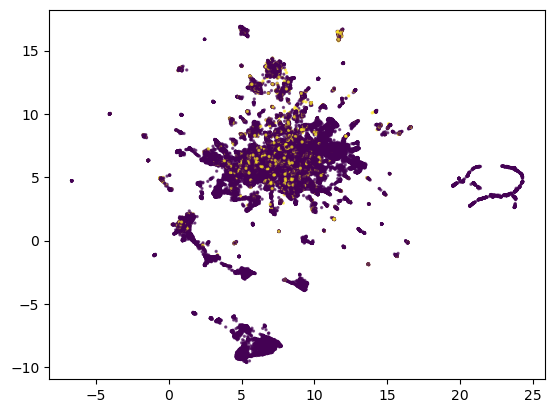

In [66]:
plt.scatter(reduction[:,0], reduction[:,1], s=2, alpha=0.6, c=all_approx_vc_mc_final['VC'])

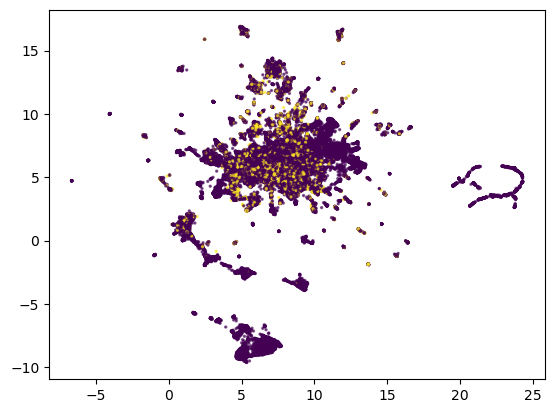

In [67]:
plt.scatter(reduction[:,0], reduction[:,1], s=2, alpha=0.6, c=all_approx_vc_mc_final['MA'])

In [ ]:
X = all_approx_vc_mc_final.drop(['VC','MA','SUBJECT_ID'],axis=1)
y = all_approx_vc_mc_final['VC']
random_forest_cl = RandomForestClassifier(n_estimators=100, random_state=30)
random_forest_cl.fit(X, y)

In [73]:
importances = random_forest_cl.feature_importances_
feat_imp_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
feat_imp_df = feat_imp_df.reset_index(drop=True)
feat_imp_df.index = feat_imp_df.index + 1
print(feat_imp_df.head(10))

   feature  importance
1    51009    0.010094
2    50813    0.009077
3    50821    0.007226
4    50818    0.006602
5    50825    0.006559
6    50808    0.006011
7    51006    0.005968
8    50965    0.005800
9    50809    0.005796
10   50820    0.005659


In [82]:
sig_parameters = feat_imp_df[0:9]['feature'].to_numpy()